In [1]:
import pandas as pd

monthly = pd.read_csv('../cargor_model_monthly.csv')
# predict on Total Cargo
monthly['Month'] = monthly['Month'].str.strip()

# serialize month
monthly['Month Val'] = pd.to_datetime(monthly['Month'], format='%Y %b')
print(monthly['Month Val'])

# Calculate the numerical representation based on the order of months
monthly['Month_Num'] = monthly['Month Val'].rank(ascending=True, method='first')
monthly_reversed = monthly.iloc[::-1].reset_index(drop=True)

0     1995-01-01
1     1995-02-01
2     1995-03-01
3     1995-04-01
4     1995-05-01
         ...    
339   2023-04-01
340   2023-05-01
341   2023-06-01
342   2023-07-01
343   2023-08-01
Name: Month Val, Length: 344, dtype: datetime64[ns]


In [2]:
import numpy as np
# x = input features (month)
# y = target variable (cargo)

features = ['Total Cargo (Thousand Tonnes)']
X = monthly_reversed['Total Cargo (Thousand Tonnes)']
y = monthly_reversed['Month_Num']


split_index = 343-10-1
X_train = X.iloc[:split_index]
y_train = y.iloc[:split_index]

X_test = X[split_index:]
y_test = y[split_index:]



In [3]:
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

res = adfuller(X_train)
print('p-value=', res[1])

res = adfuller(X_train.diff().dropna())
print('p-value=', res[1])

res = adfuller(X_train.diff().diff().dropna())
print('p-value=', res[1])

# d = 1

p-value= 0.9609305522889108
p-value= 2.9337272089638344e-08
p-value= 8.773529907073073e-16


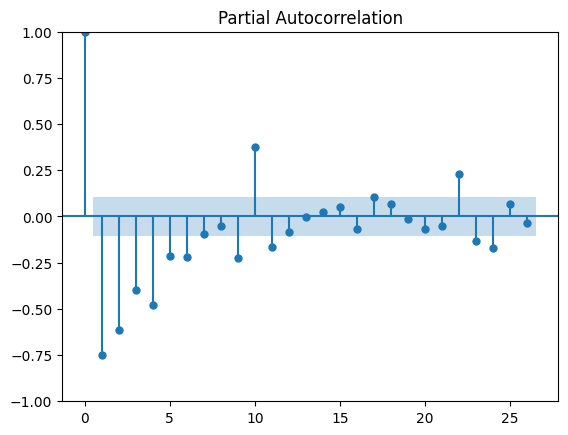

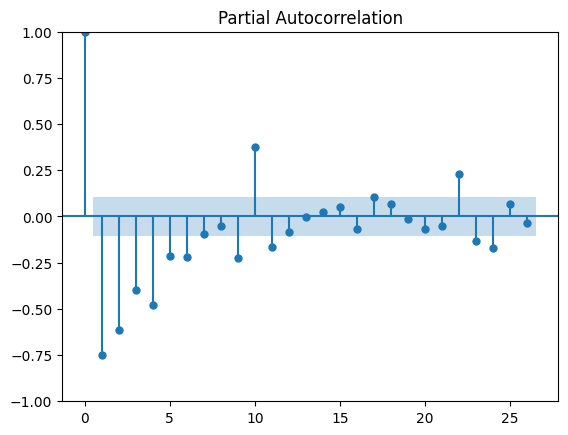

In [4]:
from statsmodels.graphics.tsaplots import plot_pacf

# plot_pacf(X)
# plot_pacf(X.diff().dropna())
plot_pacf(X_train.diff().diff().diff().dropna())

# p = 2

In [5]:
model = ARIMA(X_train, order=(1,2,1))
res = model.fit()
print(res.summary())

                                     SARIMAX Results                                     
Dep. Variable:     Total Cargo (Thousand Tonnes)   No. Observations:                  332
Model:                            ARIMA(1, 2, 1)   Log Likelihood               -3102.889
Date:                           Sat, 30 Sep 2023   AIC                           6211.778
Time:                                   17:04:25   BIC                           6223.176
Sample:                                        0   HQIC                          6216.325
                                           - 332                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0055      0.025     -0.215      0.830      -0.055       0.044
ma.L1         -0.9996      0.067    -14.990

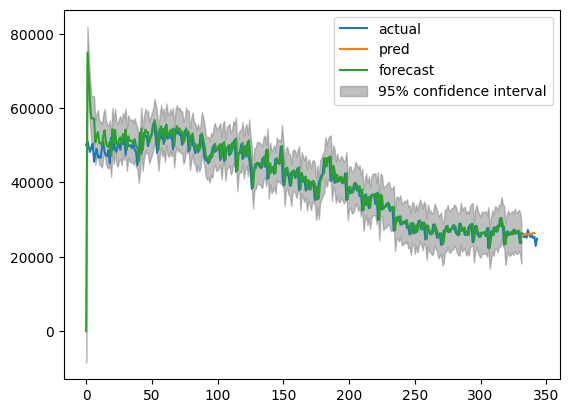

In [6]:
from statsmodels.graphics.tsaplots import plot_predict
pred = pd.Series(res.forecast(10), index=X_test.index)
fig, ax = plt.subplots()

ax = X.plot(ax=ax, label='actual')
plt.plot(pred, label='pred')
plot_predict(res, ax=ax)
plt.show()

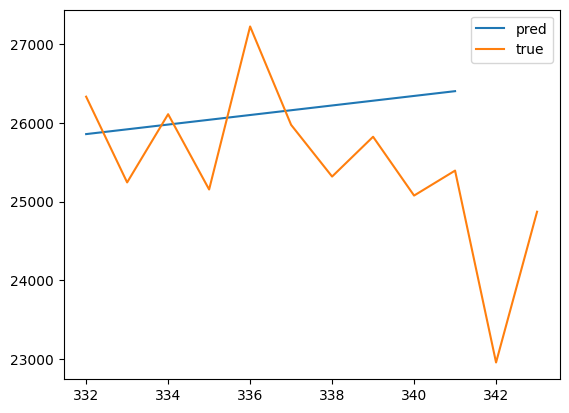

In [7]:
pred = pd.Series(res.forecast(10), index=X_test.index)
true = X_test

fig, ax = plt.subplots()

plt.plot(pred, label='pred')
plt.plot(true, label='true')
plt.legend()
plt.show()

In [8]:
n = np.array(X_test).shape[0]
d = np.abs(np.diff(np.array(X_test))).sum()/(n-1)

errors = np.abs(true - pred)
print(errors.mean()/d)

0.6106819050939654


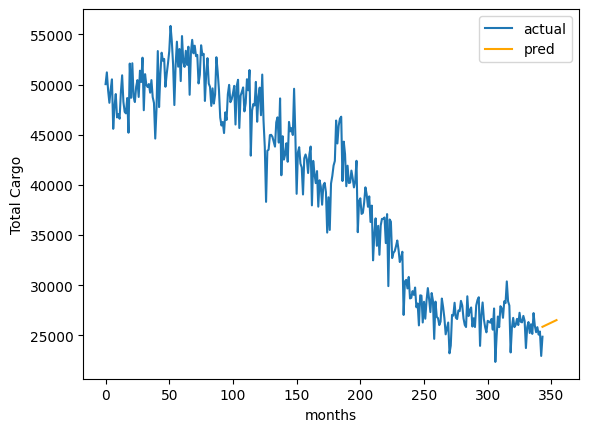

In [9]:
actual_model = ARIMA(X, order=(1,2,1))
actual_res = model.fit()

actual_forecast_range = 12
actual_pred = pd.Series(actual_res.forecast(actual_forecast_range)).reset_index(drop=True)
start_index = monthly_reversed.index[-1]
actual_pred.index = range(start_index, start_index+len(actual_pred))
fig1, ax1 = plt.subplots()
ax1 = X.plot(ax=ax1, label='actual')
plt.plot(actual_pred, label='pred', color='orange')
plt.xlabel("months")
plt.ylabel("Total Cargo")
plt.legend()
plt.show()